In [1]:
import sys

sys.path.append("../")

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from main import X_and_P_ops, RY_ansatz, VarFourier, tomatrix

np.random.seed(0)  # For reproducibility

In this notebook we show how to use our framework to obtain the ground state of the harmonic oscilator with Variational Fourier Analysis. 

We first define the number of qubits and the device for the simulation.

In [3]:
num_qubits = 4
device = qml.device("lightning.qubit", wires=num_qubits)

We then assemble the Hamiltonian of the harmonic oscilator,

$$H=\frac{1}{2}( P^2 + X^2 )$$

using `X_and_P_ops` which handles the space discretization and creates the 
`X` and `P` operators holding the information required for latter steps.

In [4]:
X, P = X_and_P_ops(range(num_qubits), x_min=-5, x_max=5)

Hamil = [X.pow(2).s_prod(0.5), P.pow(2).s_prod(0.5)]

For posterior checking, we obtain its ground state by matricial calculations.

In [5]:
Hamil_matrix = tomatrix(Hamil)

vals, vecs = np.linalg.eigh(Hamil_matrix)
val = vals[0]
vec = vecs[:, 0]
val

0.5000000011276804

Defining the initial state of the circuits and the variational circuit,

In [6]:
def init_state():
    pass

(<Figure size 1400x500 with 1 Axes>, <Axes: >)

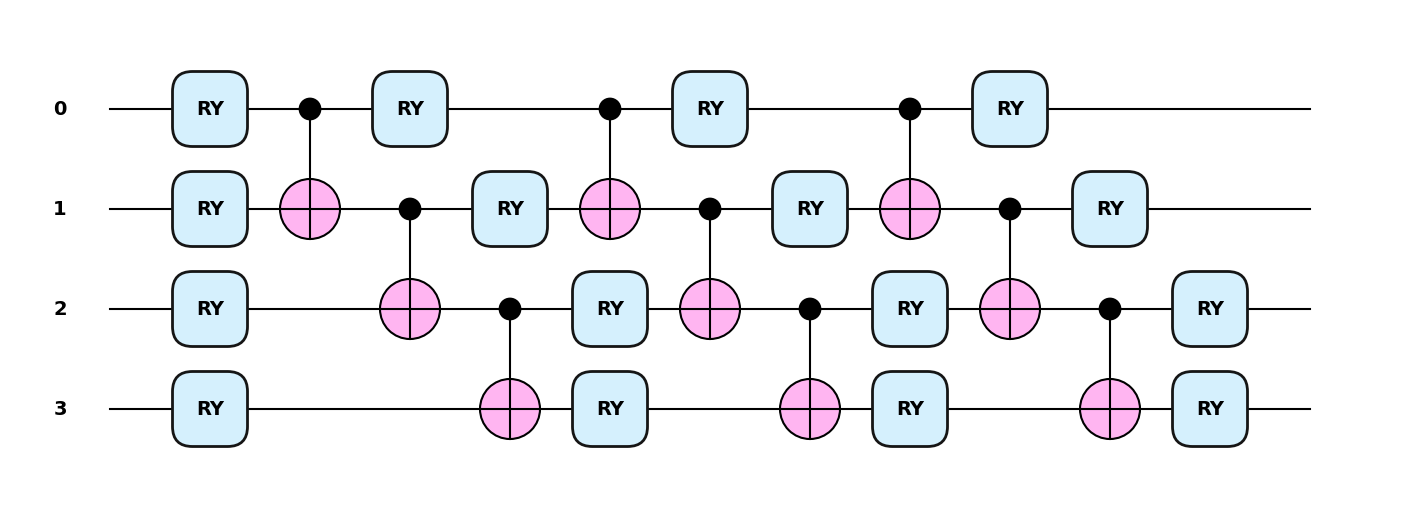

In [7]:
num_layers = 4

var_state_class = RY_ansatz(num_qubits, num_layers)
var_state = var_state_class.construct_circuit
num_params = var_state_class.num_params

qml.draw_mpl(var_state, style="pennylane")(num_params * [0])

The class ```VarFourier``` creates the solver to minimize the energy of the Hamiltonian $H$ over the variational circuit,

In [8]:
varqft = VarFourier(Hamil, device, var_state=var_state, init_state=init_state)

and the optimization is executed by the method ```VarFourier.run```. We have to include the initial condition, and the other arguments are optional.

In [9]:
params_init = np.random.randn(num_params) * 0.01

params_ground, energies_ground = varqft.run(
    params_init,
    max_iterations=500,
    learning_rate=0.1,
)

Step:    181, Energy:     0.500086


The energy trajectory during the optimization is as follows, where the red dashed line marks the lowest eigenvalue as computed at the beggining via matricial calculations.

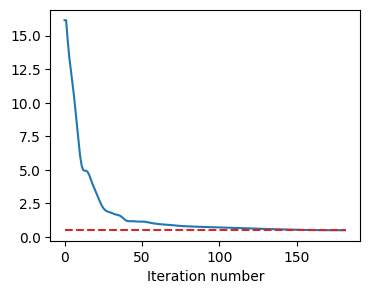

In [10]:
plt.figure(figsize=(4, 3))
plt.plot(energies_ground)
plt.xlabel("Iteration number")
plt.hlines(val, 0, len(energies_ground), colors="tab:red", linestyles="--")

Comparing the probability distribution of the estimated ground state $|\tilde{g}\rangle$ and the ideal one $|g\rangle$ we can see that they are very similar,

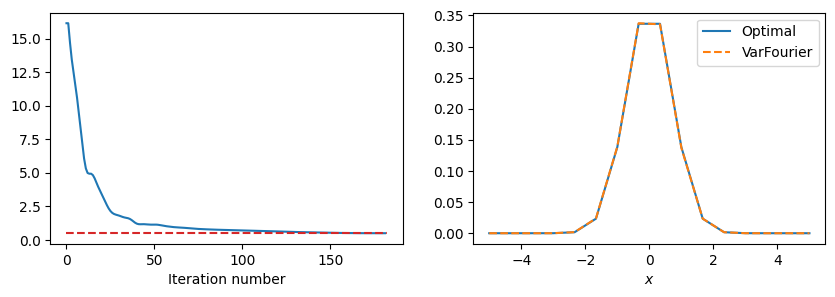

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ground_state = varqft.state(params_ground[-1])

ax[0].plot(energies_ground)
ax[0].hlines(val, 0, len(energies_ground), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[1].plot(X.eigvals(), np.abs(vec) ** 2)
ax[1].plot(X.eigvals(), np.abs(ground_state) ** 2, "--")
ax[1].set_xlabel("$ x $")
ax[1].legend(["Optimal", "VarFourier"])

and the Fidelity $F=|\langle\tilde{g}|g\rangle|^2$ between them is the following

In [12]:
abs(np.vdot(ground_state, vec)) ** 2

0.9999796051780455